**Name : Sayantani Saha**

**Roll No.: MDS202345**

In [1]:
!pip install mlflow

In [2]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay
from urllib.parse import urlparse
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset from saved CSV files
train_data = pd.read_csv("/content/train.csv")
val_data = pd.read_csv("/content/validation.csv")
test_data = pd.read_csv("/content/test.csv")

# Define features and target
X_train, y_train = train_data["message"], train_data["label"]
X_val, y_val = val_data["message"], val_data["label"]
X_test, y_test = test_data["message"], test_data["label"]

# Print dataset shapes
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (4457,), Validation set: (892,), Test set: (223,)


In [4]:
# Set the MLflow experiment
mlflow.set_experiment("Benchmark_Models")

<Experiment: artifact_location='file:///content/mlruns/846762707972949121', creation_time=1740999226052, experiment_id='846762707972949121', last_update_time=1740999226052, lifecycle_stage='active', name='Benchmark_Models', tags={}>

In [5]:
# Hyperparameter grids
param_grid = {
    "LogisticRegression": {
        'tfidf__max_features': [1000, 2000, 5000],
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear', 'saga']
    },
    "RandomForest": {
        'tfidf__max_features': [1000, 2000, 5000],
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [10, 20, None],
        'clf__min_samples_split': [2, 5, 10]
    },
    "DecisionTree": {
        'tfidf__max_features': [1000, 2000, 5000],
        'clf__max_depth': [10, 20, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__criterion': ['gini', 'entropy']
    },
    "SVC": {
        'tfidf__max_features': [1000, 2000, 5000],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale', 'auto']


    },
}

# Define models
models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=2000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42)  # Ensure predict_proba is available
}


In [6]:
# Function to train and log models
def train_and_log_model(model_name, model, tune_hyperparams=False):
    print(f"\n🔍 Training {model_name} (Hyperparameter Tuning: {tune_hyperparams})...")

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', model)
    ])

    if tune_hyperparams and model_name in param_grid:
        search = GridSearchCV(pipeline, param_grid[model_name], cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
        pipeline = search.fit(X_train, y_train).best_estimator_  # Get best pipeline
        best_params = search.best_params_
    else:
        pipeline.fit(X_train, y_train)
        best_params = None

    # Predictions on validation set
    y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    # Compute AUCPR
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
    aucpr = auc(recall, precision)

    # Log results in MLflow
    with mlflow.start_run(run_name=f"{model_name}_Hyperparameter_Tuning" if tune_hyperparams else model_name):
        if best_params:
            mlflow.log_params(best_params)
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric("Validation_AUCPR", aucpr)
        mlflow.sklearn.log_model(pipeline, f"Best_{model_name}_Model")

    # Print results
    print(f"✅ {model_name}: Validation AUCPR = {aucpr:.4f}")

    return pipeline, aucpr

In [7]:
# Train models with hyperparameter tuning for Logistic Regression and Random Forest
trained_models = {}
aucpr_scores = {}

for name, model in models.items():
    tune_hyperparams = name in ["LogisticRegression", "RandomForest", "DecisionTree" ]
    trained_models[name], aucpr_scores[name] = train_and_log_model(name, model, tune_hyperparams)

# Print AUCPR scores
print("\n📊 Benchmark Model AUCPR Scores:")
for name, score in aucpr_scores.items():
    print(f"{name}: {score:.4f}")

# Final evaluation on test set using the best model
best_model_name = max(aucpr_scores, key=aucpr_scores.get)
best_model = trained_models[best_model_name]

y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
aucpr_test = auc(recall, precision)

print(f"\n🏆 Final Evaluation on Test Set - {best_model_name}: AUCPR = {aucpr_test:.4f}")

# Confusion Matrix
y_test_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


🔍 Training LogisticRegression (Hyperparameter Tuning: True)...
Fitting 3 folds for each of 60 candidates, totalling 180 fits


2025/03/03 11:29:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression: Validation AUCPR = 0.9917

🔍 Training RandomForest (Hyperparameter Tuning: True)...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


2025/03/03 11:32:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ RandomForest: Validation AUCPR = 0.9878

🔍 Training DecisionTree (Hyperparameter Tuning: True)...
Fitting 3 folds for each of 162 candidates, totalling 486 fits


2025/03/03 11:33:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ DecisionTree: Validation AUCPR = 0.8323

🔍 Training SVC (Hyperparameter Tuning: False)...


2025/03/03 11:34:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ SVC: Validation AUCPR = 0.9922

📊 Benchmark Model AUCPR Scores:
LogisticRegression: 0.9917
RandomForest: 0.9878
DecisionTree: 0.8323
SVC: 0.9922

🏆 Final Evaluation on Test Set - SVC: AUCPR = 0.9980

Confusion Matrix:
 [[201   0]
 [  1  21]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      0.95      0.98        22

    accuracy                           1.00       223
   macro avg       1.00      0.98      0.99       223
weighted avg       1.00      1.00      1.00       223



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.95      1.00      0.98        21

    accuracy                           1.00       223
   macro avg       0.98      1.00      0.99       223
weighted avg       1.00      1.00      1.00       223



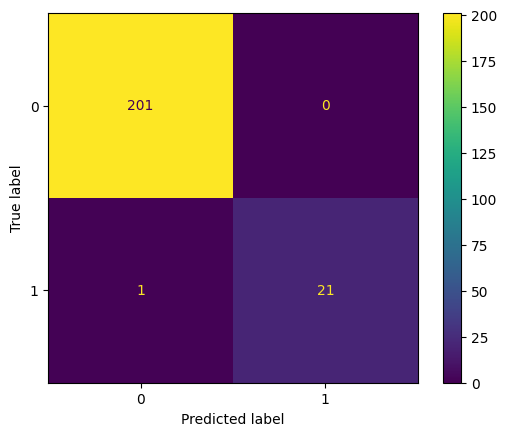

In [8]:
# Predict on test set using the best model (SVC)
pred_y = best_model.predict(X_test)

# Print classification report
print(classification_report(pred_y, y_test))

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()
